# Find Missing Part of Spherical Data

This can be combined with `superellipsoid_fibonacci_projection_sampling.ipynb` for find missing parts of superellipsoids.

In [ ]:
import numpy as np
#from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

def animate(f):
    # Generate Animation
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111, projection='3d')

    f(fig, ax)
    
    def update(frame):
        ax.view_init(frame/8, frame)
        return

    ani = FuncAnimation(fig, update, frames=np.linspace(0, 360, 180), init_func=None, blit=False, interval=66)
    plt.close()
    return ani.to_html5_video()

def animate2(f):
    # Generate Animation
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111, projection='3d')
    
    def update(frame):
        ax.clear()
        f(fig, ax, frame)
        ax.view_init(frame/8, frame)
        return

    ani = FuncAnimation(fig, update, frames=np.linspace(0, 360, 180), init_func=None, blit=False, interval=66)
    plt.close()
    return ani.to_html5_video()

## Fibonacci Sphere

In [1]:
def fibonacci_sphere(samples=1000):
    points = np.zeros((samples, 3))
    phi = np.pi * (3 - np.sqrt(5))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / (samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points[i] = [x, y, z]

    return points

In [15]:
def f(fig, ax, frame):
    n = int(frame)+5
    points = fibonacci_sphere(n)
    ax.set_title("$N={}$".format(n))
    ax.scatter(points[:,0],points[:,1],points[:,2], c=points[:,2])
HTML(animate2(f))

## Generating Noisy Data with Missing Parts

In [16]:
def fibonacci_sphere_noisy(samples=1000):
    points = np.zeros((samples, 3))
    phi = np.pi * (3 - np.sqrt(5))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / (samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta + np.random.uniform(-0.25, 0.25)) * radius
        z = np.sin(theta + np.random.uniform(-0.25, 0.25)) * radius

        points[i] = [x, y, z]
        points[i] = points[i] / np.linalg.norm(points[i])

    return points

def fruit():
    points = fibonacci_sphere_noisy(200)
    mask = points[:,0] + points[:,1] < 0.6
    points = points[mask,:]
    return points
    
def f(fig, ax):
    points = fruit()
    ax.scatter(points[:,0],points[:,1],points[:,2], c=points[:,2])
HTML(animate(f))

## Map Sample Points to Theta/Azimuth Grid (Failed)

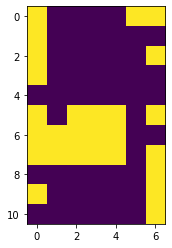

In [4]:
from scipy import ndimage

def find_openings(points, debug=False):
    theta_size = 10
    azimuth_size = 6
    checkboard = np.ones((theta_size+1, azimuth_size+1))
    
    x,y,z = points[:,0], points[:,1], points[:,2]
    
    theta = np.arctan2(y, x) + np.pi
    azimuth = np.arccos(z)
    
    theta_idx = np.round( theta_size * theta / (2*np.pi) ).astype(np.int32)
    azimuth_idx = np.round( azimuth_size * azimuth / np.pi ).astype(np.int32)
    
    #theta_idx = theta_idx % theta_size
    #azimuth_idx = azimuth_idx % azimuth_size
    
    for i,j in zip(theta_idx, azimuth_idx):
        checkboard[ i, j  ] = 0

    #checkboard = np.pad(checkboard, 5, mode="wrap")
    #checkboard = ndimage.binary_erosion(checkboard, iterations=1)
    #checkboard = checkboard[5:-5, 5:-5] #unpad
    
    if debug:
        plt.imshow(checkboard)
        plt.show()
    
    ii, jj = checkboard.nonzero()
    
    for i,j in zip(ii, jj):
        theta = 2*np.pi*i/theta_size - np.pi
        azimuth = np.pi*j/azimuth_size
        
        x_ = np.cos(theta) * np.sin(azimuth)
        y_ = np.sin(theta) * np.sin(azimuth)
        z_ = np.cos(azimuth)
        
        if not debug:
            plt.plot(x_, y_, z_, "or", alpha=0.5)

points = fruit()
open_points = find_openings(points, debug=True)

def f(fig, ax):
    open_points = find_openings(points)
    x,y,z = points[:,0], points[:,1], points[:,2]
    ax.plot(x.flatten(),y.flatten(),z.flatten(), "k.")
HTML(animate(f))

**PROBLEM:** 

There are not enough points near to the poles. Sampling density is too high at the poles.

**IDEAS:**

- use icosahedron (a regular convex polyhedron with 20 faces) + subdivide faces?
  - Nope...

- Sample fibonacci sphere and find sphere points with less or no neighbors. Project data points onto the a standard sphere before processing.
  - Parameters are: mean distance threshold and number of neighbors.
  - Distance threshold should be set correctly to prevent false positives.
  - Increasing number of neighbors may help against noise (if there are enough data points) and give result closer to the border of missing section.

## Find Fibonacci Sphere Samples with No Neighbors from Input

Worked quite well.

**Note:** If input data is superellipsoid-like then sampling superellipsoids instead of directly using fibonacci sphere samples may be needed. Also see: `superellipsoid_fibonacci_projection_sampling.ipynb`

In [6]:
from sklearn.neighbors import KDTree

def find_openings(points, n=50):
    tree = KDTree(points)
    sphere = fibonacci_sphere(n)
    dist, ind = tree.query(sphere, k=5)
    dist_ = dist.mean(axis=1)
    threshold = 0.3
    mask = dist_ > threshold
    openings = sphere[mask]
    return openings

In [7]:
points = fruit()

def f(fig, ax):
    open_points = find_openings(points)
    x,y,z = open_points[:,0], open_points[:,1], open_points[:,2]
    ax.plot(x.flatten(),y.flatten(),z.flatten(), "r.")
    x,y,z = points[:,0], points[:,1], points[:,2]
    ax.plot(x.flatten(),y.flatten(),z.flatten(), "k.")
HTML(animate(f))

In [18]:
points = fruit()

def f(fig, ax, frame):
    n = int(frame)+5
    open_points = find_openings(points, n)  
    ax.plot(open_points[:,0],open_points[:,1],open_points[:,2], ".r")
    ax.set_title("$N={}$".format(n))
    ax.plot(points[:,0],points[:,1],points[:,2], ".k")
HTML(animate2(f))